### Importing libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import json
import pickle
import pywt
%matplotlib inline

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
## Read the image
img = cv2.imread('/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/angry/Angry10.png')
img.shape

(173, 173, 3)

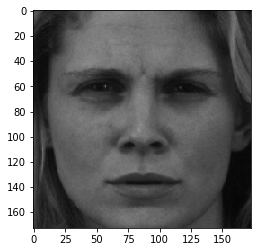

In [39]:
plt.imshow(img)
plt.show()

In [40]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(173, 173)

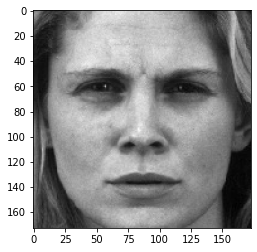

In [41]:
plt.imshow(gray, cmap='gray')
plt.show()

### LBP

In [42]:
def lbp(image):
  def assign_bit(picture, x, y, c):   #comparing bit with threshold value of centre pixel
      bit = 0  
      try:          
          if picture[x][y] >= c: 
              bit = 1         
      except: 
          pass
      return bit 
  def local_bin_val(picture, x, y):  #calculating local binary pattern value of a pixel
      eight_bit_binary = []
      centre = picture[x][y] 
      powers = [1, 2, 4, 8, 16, 32, 64, 128] 
      decimal_val = 0
      #starting from top right,assigning bit to pixels clockwise 
      eight_bit_binary.append(assign_bit(picture, x-1, y + 1,centre)) 
      eight_bit_binary.append(assign_bit(picture, x, y + 1, centre)) 
      eight_bit_binary.append(assign_bit(picture, x + 1, y + 1, centre)) 
      eight_bit_binary.append(assign_bit(picture, x + 1, y, centre)) 
      eight_bit_binary.append(assign_bit(picture, x + 1, y-1, centre)) 
      eight_bit_binary.append(assign_bit(picture, x, y-1, centre)) 
      eight_bit_binary.append(assign_bit(picture, x-1, y-1, centre)) 
      eight_bit_binary.append(assign_bit(picture, x-1, y, centre))     
      #calculating decimal value of the 8-bit binary number
      for i in range(len(eight_bit_binary)): 
          decimal_val += eight_bit_binary[i] * powers[i] 
            
      return decimal_val 
  m, n, _ = image.shape 
  gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  #converting image to grayscale
  lbp_image = np.zeros((m, n),np.uint8) 
  # converting image to lbp
  for i in range(0,m): 
      for j in range(0,n): 
          lbp_image[i, j] = local_bin_val(gray_scale, i, j) 
 
  return lbp_image

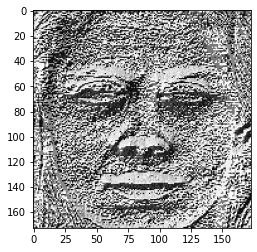

array([[ 10,   0,  62, ...,  56,  58,   0],
       [  5, 238,  93, ..., 124, 125, 248],
       [143,  26,   0, ..., 120,  60,  56],
       ...,
       [128,  96, 232, ..., 240, 255, 216],
       [137, 255,  72, ..., 246,  64, 176],
       [128,  99,   0, ..., 227, 128, 224]], dtype=uint8)

In [43]:
l=lbp(img)
from matplotlib import pyplot as plt
plt.imshow(l, cmap ="gray") 
plt.show()
l

In [44]:
### Training dataset
datadirectory = '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/'

In [45]:
img_dirs = []
for entry in os.scandir(datadirectory):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [46]:
img_dirs

['/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/fear',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/sad',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/angry',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/happy',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/surprise',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/neutral',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 

In [47]:
emotions = []
for img_dir in img_dirs:
    emotion_name = img_dir.split('/')[-1]
    emotions.append(emotion_name)

In [48]:
emotions

['fear', 'sad', 'angry', 'happy', 'surprise', 'neutral', 'disgust']

### Read all the images and converting them into array

In [49]:
training_data = []

for emotion in emotions:
    path = os.path.join(datadirectory, emotion)
    label = emotions.index(emotion)
    print('{} --> {}'.format(emotion, label))
    for img in os.listdir(path):
        imgpath = os.path.join(path, img)
        img = cv2.imread(imgpath)
        img = cv2.resize(img, (48, 48))
        lbpImg = lbp(img)
        image = np.array(lbpImg).flatten() 
        training_data.append([image, label])

fear --> 0
sad --> 1
angry --> 2
happy --> 3
surprise --> 4
neutral --> 5
disgust --> 6


In [50]:
print(len(training_data))

4336


In [51]:
import random 
random.shuffle(training_data)

In [52]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

### Splitting the data into training and test set

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Training the model with different machine learning models

In [54]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [55]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [21]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.695507,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.480108,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.578441,{'logisticregression__C': 1}


In [22]:
best_estimators

{'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=10, gamma='auto', probability=True))])}

In [23]:
best_estimators['svm'].score(X_test,y_test)

0.7269585253456221

In [24]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.6255760368663594

In [25]:
best_estimators['random_forest'].score(X_test,y_test)

0.4965437788018433

In [26]:
best_clf_svm = best_estimators['svm']

In [27]:
best_clf_svm

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, gamma='auto', probability=True))])

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, best_clf_svm.predict(X_test))
cm

array([[ 75,   5,  11,   3,  17,   9,   2],
       [ 15,  59,   5,   5,   6,  20,   2],
       [  5,   6,  86,   7,   7,   9,  10],
       [  3,   1,   1, 125,   6,   1,   7],
       [  9,   5,   6,   3,  89,   3,   0],
       [  3,   3,   4,   0,   8, 105,   0],
       [  0,   7,  13,   7,   2,   1,  92]])

Text(69.0, 0.5, 'Truth')

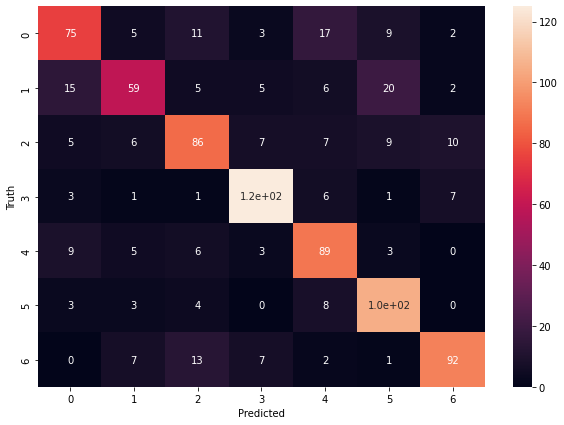

In [29]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [30]:
cr_svm = classification_report(y_test, best_clf_svm.predict(X_test))
print(cr_svm)

              precision    recall  f1-score   support

           0       0.68      0.61      0.65       122
           1       0.69      0.53      0.60       112
           2       0.68      0.66      0.67       130
           3       0.83      0.87      0.85       144
           4       0.66      0.77      0.71       115
           5       0.71      0.85      0.77       123
           6       0.81      0.75      0.78       122

    accuracy                           0.73       868
   macro avg       0.72      0.72      0.72       868
weighted avg       0.73      0.73      0.72       868



In [ ]:
best_clf_logistic_reg = best_estimators['logistic_regression']

In [ ]:
best_clf_logistic_reg

In [ ]:
from sklearn.metrics import confusion_matrix
cm_logistic_reg = confusion_matrix(y_test, best_clf_logistic_reg.predict(X_test))
cm_logistic_reg

Text(69.0, 0.5, 'Truth')

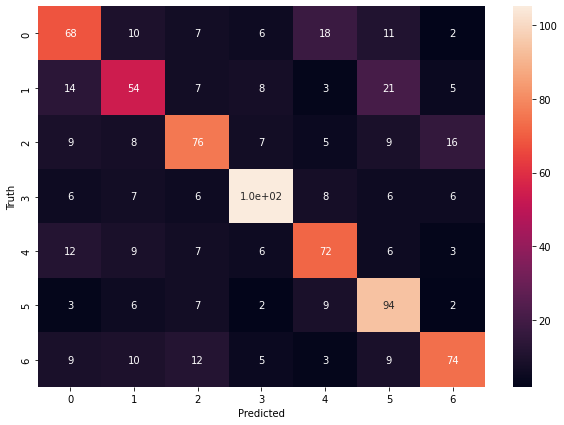

In [34]:
plt.figure(figsize = (10,7))
sns.heatmap(cm_logistic_reg, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
# with open("/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5 with wavelet transform/Models/model5-wavelet-transform.pkl", "wb") as f:
#   pickle.dump(best_clf_svm, f)